In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

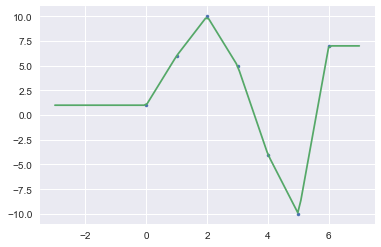

In [198]:
x = np.array([1, 6, 10, 5, -4, -10, 7])
t = np.linspace(-3, 7, 100)
frac, floor = np.modf(t)

floor_range = np.clip(t.astype('int'), 0, len(x) - 1)
floor_next_range = np.clip((t + 1).astype('int'), 0, len(x) - 1)

xfirst = x[floor_range]
xnext = x[floor_next_range]
          
interp = xfirst + frac * (xnext - xfirst)

plt.plot(x, '.')
plt.plot(t, interp)


In [153]:
interp

array([ 8.4,  7.5])

In [228]:
# Sinc interpolation example
def interpol(t, x, intertype='sinc'):
    '''Given a signal x and a list of timestamps t
    Return the sinc interpolation at the timestamps'''
    if intertype == 'sinc':
        k = np.arange(len(x))
        tval, kval = np.meshgrid(t, k)
        ktmat = np.sinc(tval - kval)
        return np.dot(ktmat.T, x)
    elif intertype == 'linear':
        frac, floor = np.modf(t)
        floor_range = np.clip(t.astype('int'), 0, len(x) - 1)
        floor_next_range = np.clip((t + 1).astype('int'), 0, len(x) - 1)

        xfirst = x[floor_range]
        xnext = x[floor_next_range]

        return xfirst + frac * (xnext - xfirst)

def deriv_sinc(x):
    '''Derivative of the sinc function'''
    x[x == 0] = 10**-10
    return (x * np.cos(x) - np.sin(x)) / x**2

def total_cost(x, y, a, intertype='sinc'):
    '''Given x(t) and y(t), find ||x(at) - y(t)||**2'''
    N = min(int(len(x) / a), len(y))
    tvals = a * np.arange(int(len(x) / a))   
    x_stretch = interpol(tvals, x, intertype)
    
    return x_stretch[:N], np.sum((x_stretch[:N] - y[:N])**2) / N

def do_stretch(x, stretch, intertype='sinc'):
    '''Given: signal, x and stretch factor
    Returns array of t and x(t) stretched by that factor'''
    tvals = stretch * np.arange(int(len(x) / stretch))
    x_stretch = interpol(tvals, x, intertype)
    return tvals, x_stretch
    

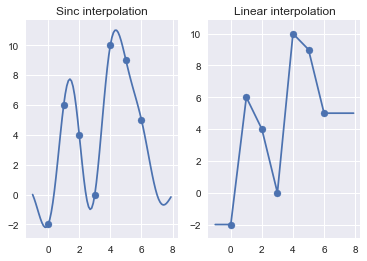

In [204]:
x = np.array([-2, 6,4,0,10, 9, 5])
t = np.arange(-1, 8, 0.1)
plt.subplot('121')
plt.plot(t, interpol(t, x, 'sinc'))
plt.scatter(range(len(x)), x)
plt.title('Sinc interpolation')

plt.subplot('122')
plt.plot(t, interpol(t, x, 'linear'))
plt.scatter(range(len(x)), x)
plt.title('Linear interpolation')

In [ ]:
def find_gradient(t, x):
    '''Given a signal x and a list of timestamps t
    Return the gradient at the timestamps'''
    

In [208]:
# Read in the neural data
short_psth = np.genfromtxt('./Raws/psth_short_all_neurons_nans_171102.csv', delimiter=',')
long_psth = np.genfromtxt('./Raws/psth_long_all_neurons_nans_171102.csv', delimiter=',')

t_points_short = 7
t_points_long = 9
n_neurons = 105
dt_bin = 40 #ms

# Reshape the short and long raw data into tensors
reshaped_short_psth = np.reshape(short_psth, (n_neurons, t_points_short, -1))
reshaped_long_psth = np.reshape(long_psth, (n_neurons, t_points_long, -1))
duration_short = reshaped_short_psth.shape[2]
duration_long = reshaped_long_psth.shape[2]

# Combine short and long trials into one tensor
reshaped_short_pad = np.lib.pad(reshaped_short_psth, ((0,0), (0,0), 
                                                      (0, duration_long-duration_short)), 
                                'constant', constant_values=(np.nan, np.nan))
reshaped_all_pad = np.concatenate((reshaped_short_pad, reshaped_long_psth), axis=1)

# Swap axes to feed in twpca
swapped_all = np.swapaxes(reshaped_all_pad, 0, 2)
swapped_all = np.swapaxes(swapped_all, 0, 1)

# Define palette used in plotting
palette_blue = sns.palettes.color_palette('Blues', t_points_short)
palette_red = sns.palettes.color_palette('Reds', t_points_long)

In [229]:
def get_stretch_neuron(all_neurons, neuron_id, stretches, intertype='sinc'):
    '''Input: all_neurons: array of all neurons
    neuron_id: neuron of interest
    stretches: possible stretches to consider
    Returns the array of stretch for each condition'''
    sref = all_neurons[neuron_id, -1, :]
    sref = sref[~np.isnan(sref)] / np.nanmax(sref)
    
    min_stretch = []

    for i in range(all_neurons.shape[1]):
        s1 = all_neurons[neuron_id, i, :]
        s1 = s1[~np.isnan(s1)] / np.nanmax(s1)
        cost = []
        for stretch in stretchlst:
            xs, cost_single = total_cost(s1, sref, stretch, intertype)
            cost.append(cost_single)
        min_stretch.append(stretchlst[np.argmin(cost)])
    return np.array(min_stretch)

def visualize_stretch(all_neurons, neuron_id, trial, stretch, intertype='sinc'):
    '''Given a neuronID and the stretch amount,
    plot the stretched trial'''
    sref = all_neurons[neuron_id, -1, :]
    sref = sref[~np.isnan(sref)] / np.nanmax(sref)
    s1 = all_neurons[neuron_id, trial, :]
    s1 = s1[~np.isnan(s1)] / np.nanmax(s1)
    _, x = do_stretch(s1, stretch, intertype)
    plt.plot(sref, '--', label='Reference')
    plt.plot(s1, label='Before')
    plt.plot(x, label='After')
    plt.legend()
    

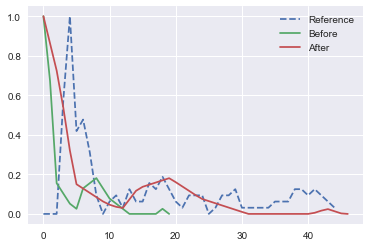

In [231]:
visualize_stretch(reshaped_all_pad, 10, 3, 0.42, 'linear')

In [104]:
min_stretch

array([ 0.42,  0.42,  0.42,  0.23,  0.21,  0.46,  0.48,  0.37,  0.77,
        0.58,  0.71,  0.84,  0.63,  0.54,  0.68,  0.99])

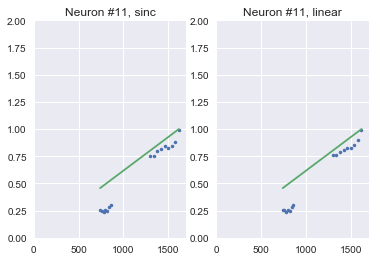

In [248]:
stretchlst = np.arange(0.1, 1.0, 0.01)
n_neuron = 11
min_stretch_sinc = get_stretch_neuron(reshaped_all_pad, n_neuron, stretchlst, 'sinc')
min_stretch_linear = get_stretch_neuron(reshaped_all_pad, n_neuron, stretchlst, 'linear')
times = np.array([740, 760, 780, 800, 820, 840, 860, 1300, 1340, 1380, 1420, 1460, 1500, 1540, 1580, 1620])

plt.subplot('121')
plt.plot(times, min_stretch_sinc, '.')
plt.xlim(0, 1700)
plt.ylim(0, 2)
plt.plot(times, times / 1620)
plt.title('Neuron #' + str(n_neuron) + ', sinc')

plt.subplot('122')
plt.plot(times, min_stretch_linear, '.')
plt.xlim(0, 1700)
plt.ylim(0, 2)
plt.plot(times, times / 1620)
plt.title('Neuron #' + str(n_neuron) + ', linear')


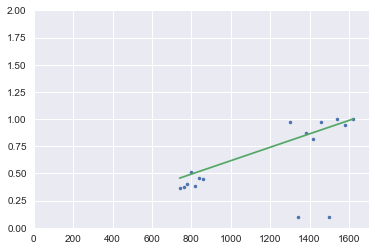

In [61]:
ntimes = 15
neuron = 23
sref = reshaped_all_pad[neuron, -1, :]
sref = sref[~np.isnan(sref)] / np.nanmax(sref)
stretchlst = np.arange(0.1, 1.0, 0.001)

min_stretch = []
for i in range(16):
    s1 = reshaped_all_pad[neuron, i, :]
    s1 = s1[~np.isnan(s1)] / np.nanmax(s1)
    cost = []
    for a in stretchlst:
        xs, cost_single = total_cost(s1, sref, a)
        cost.append(cost_single)
    min_stretch.append(stretchlst[np.argmin(cost)])
    #print(stretchlst[np.argmin(cost)])

times = np.array([740, 760, 780, 800, 820, 840, 860, 1300, 1340, 1380, 1420, 1460, 1500, 1540, 1580, 1620])
plt.plot(times, np.array(min_stretch), '.')
plt.xlim(0, 1700)
plt.ylim(0, 2)
plt.plot(times, times / 1620)